In [1]:
import functools

import numpy as np
import tensorflow as tf
import scipy
import scipy.linalg
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

In [2]:
reg = keras.regularizers.l1_l2(l1=1e-5, l2=1e-5)
#reg = None

regularize = lambda f: functools.partial(f,
                           kernel_regularizer=reg,
                           bias_regularizer=reg,
                           kernel_initializer='he_normal',
                           bias_initializer='he_normal',)

Conv2D = regularize(layers.Conv2D)
Dense = regularize(layers.Dense)

In [3]:
# Load data.
images = np.load("images.npy")
labels = np.load("labels.npy")
print(images.shape, labels.shape)

(18000, 150, 150) (18000, 2)


In [4]:
# Preprocess data.
X = images.reshape(images.shape + (1,))

# Translate labels into one-hot encoding.
n = labels.shape[0]
hour_labels = labels[:,0]
minute_labels = labels[:,1]

# We actually encode half-hours to disambiguate 59/0 minutes later.
y_real = hour_labels * 60 + minute_labels
y_hours = np.zeros((n, 24))
y_hours[np.arange(n), 2 * y_real // 60] = 1
y_minutes = np.zeros((n, 60))
y_minutes[np.arange(n), minute_labels] = 1
y = np.column_stack([y_hours, y_minutes])

def split_hours_minutes(y):
    return y[...,:24], y[...,24:]

# Reverse transform.
def decode_onehot(y, lib=np):
    y_hours, y_minutes = split_hours_minutes(y)
    half_hours = lib.argmax(y_hours, axis=1)
    minutes = lib.argmax(y_minutes, axis=1)
    hours = half_hours // 2
    second_half_hour = (half_hours - 2*hours) == 1
    if lib is np:
        hours += second_half_hour & (minutes <= 15)
        hours -= ~second_half_hour & (minutes >= 45)
    else:
        hours += lib.cast(second_half_hour & (minutes <= 15), 'int64')
        hours -= lib.cast(~second_half_hour & (minutes >= 45), 'int64')
    return (hours * 60 + minutes) % (12*60)

(X_train, X_test,
 y_train, y_test,
 y_real_train, y_real_test) = train_test_split(X, y, y_real, test_size=0.2, random_state=42)

def cyclic_error_minutes(true, pred, lib=np):
    M = 12*60
    err = lib.abs(true - pred) % M
    return lib.minimum(err, M - err)

In [5]:
# Define neural network architecture.
def norm_act_conv(x, filters, kernel_size, strides=(1, 1), activation=True, padding='same'):
    x = layers.BatchNormalization()(x)
    if activation: x = layers.ReLU()(x)
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    return x

def residual_bottleneck_block_v2(input_tensor, filters, half_resolution):
    input_filters = input_tensor.shape[-1]
    downscale_strides = (2, 2) if half_resolution else (1, 1)
    
    y = input_tensor
    x = norm_act_conv(input_tensor,   filters, (1, 1))
    x = norm_act_conv(x,              filters, (3, 3), strides=downscale_strides)
    x = norm_act_conv(x,            4*filters, (1, 1))
    
    if x.shape[1:] != y.shape[1:]:
        y = Conv2D(4*filters, (1, 1), strides=downscale_strides)(y)

    return layers.ReLU()(layers.add([x, y]))

def resnet50_v2(input_tensor):
    x = layers.ZeroPadding2D(padding=(3, 3))(input_tensor)
    x = Conv2D(64, (7, 7),  strides=(2, 2), padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    for i in range(3): x = residual_bottleneck_block_v2(x, 64, False)
    for i in range(4): x = residual_bottleneck_block_v2(x, 128, i == 0)
    for i in range(6): x = residual_bottleneck_block_v2(x, 256, i == 0)
    for i in range(3): x = residual_bottleneck_block_v2(x, 512, i == 0)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def clocknet_classify(input_tensor):
    x = resnet50_v2(input_tensor)
    x = layers.GlobalAveragePooling2D()(x)
    x = Dense(1000)(x)
    x = layers.BatchNormalization()(x)
    resnet_out = layers.ReLU()(x)
    hours = Dense(24, name='hours_out', activation='softmax', kernel_regularizer=None, bias_regularizer=None)(resnet_out)
    minutes = Dense(60, name='minutes_out', activation='softmax', kernel_regularizer=None, bias_regularizer=None)(resnet_out)
    return hours, minutes

In [20]:
def cyclic_weighted_cross_entropy(n, weight):
    cce = keras.losses.CategoricalCrossentropy()
    circ = scipy.linalg.circulant(np.arange(n)).T
    cost_mat = np.minimum(circ, n - circ).astype('float32')
    
    def loss_func(y_true, y_pred):        
        y_pred_max_mat = K.one_hot(K.argmax(y_pred), num_classes=y_pred.shape[1])
        actual_error = K.sum((y_true @ cost_mat) * y_pred_max_mat, -1)
        expected_error = K.sum((y_true @ cost_mat) * y_pred, -1)
        sample_weight = 1 + expected_error * weight
        return K.mean(K.categorical_crossentropy(y_true, y_pred) * sample_weight)
    
    return loss_func

def time_loss():
    hour_loss = cyclic_weighted_cross_entropy(24, 30)
    minute_loss = cyclic_weighted_cross_entropy(60, 1)
    def loss(y_true, y_pred):
        y_true_hours, y_true_minutes = split_hours_minutes(y_true)
        y_pred_hours, y_pred_minutes = split_hours_minutes(y_pred)
        return hour_loss(y_true_hours, y_pred_hours) + minute_loss(y_true_minutes, y_pred_minutes)
    return loss

def hour_accuracy(y_true, y_pred):
    y_true_hours, y_true_minutes = split_hours_minutes(y_true)
    y_pred_hours, y_pred_minutes = split_hours_minutes(y_pred)
    return keras.metrics.categorical_accuracy(y_true_hours, y_pred_hours)

def minute_accuracy(y_true, y_pred):
    y_true_hours, y_true_minutes = split_hours_minutes(y_true)
    y_pred_hours, y_pred_minutes = split_hours_minutes(y_pred)
    return keras.metrics.categorical_accuracy(y_true_minutes, y_pred_minutes)

def real_time_error(y_true, y_pred):
    true_time = K.cast(decode_onehot(y_true, lib=K), 'float64')
    pred_time = K.cast(decode_onehot(y_pred, lib=K), 'float64')
    return cyclic_error_minutes(true_time, pred_time, lib=K)

def create_model():
    inp = layers.Input((150, 150, 1))
    cnh, cnm = clocknet_classify(inp)
    out = layers.concatenate([cnh, cnm], name='time')
    model = keras.Model(inputs=inp, outputs=out)
    return model

In [7]:
model = create_model()

filepath = "D:/study/models4/model-adam-{epoch:02d}.hdf5"
csv_logger = keras.callbacks.CSVLogger('adam_training.log')
checkpoint = keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_best_only=False)

model.compile(loss=time_loss(), optimizer='adam', metrics=[hour_accuracy, minute_accuracy, real_time_error])
hist1 = model.fit(X_train,
                  y_train,
                  validation_data=(X_test, y_test),
                  callbacks=[csv_logger, checkpoint],
                  batch_size=24, verbose=True, epochs=100)


filepath = "D:/study/models4/model-sgd-{epoch:02d}.hdf5"
csv_logger = keras.callbacks.CSVLogger('sgd_training.log')
checkpoint = keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_best_only=False)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 0.95**epoch)
sgd = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=time_loss(), optimizer=sgd, metrics=[hour_accuracy, minute_accuracy, real_time_error])
hist2 = model.fit(X_train,
                  y_train,
                  validation_data=(X_test, y_test),
                  callbacks=[csv_logger, checkpoint, lr_scheduler],
                  batch_size=24, verbose=True, epochs=100)

Train on 14400 samples, validate on 3600 samples
Epoch 1/100
14376/14400 [============================>.] - ETA: 0s - loss: 487.0463 - hour_accuracy: 0.1463 - minute_accuracy: 0.0290 - real_time_error: 121.6997
Epoch 00001: saving model to D:/study/models4/model-adam-01.hdf5
14400/14400 [==============================] - 123s 9ms/sample - loss: 486.7834 - hour_accuracy: 0.1462 - minute_accuracy: 0.0290 - real_time_error: 121.6648 - val_loss: 1754.4505 - val_hour_accuracy: 0.0622 - val_minute_accuracy: 0.0219 - val_real_time_error: 139.0205
Epoch 2/100
14376/14400 [============================>.] - ETA: 0s - loss: 207.5141 - hour_accuracy: 0.3949 - minute_accuracy: 0.0484 - real_time_error: 56.2084
Epoch 00002: saving model to D:/study/models4/model-adam-02.hdf5
14400/14400 [==============================] - 108s 7ms/sample - loss: 207.3569 - hour_accuracy: 0.3951 - minute_accuracy: 0.0484 - real_time_error: 56.1636 - val_loss: 783.0214 - val_hour_accuracy: 0.1653 - val_minute_accuracy:

Epoch 18/100
14376/14400 [============================>.] - ETA: 0s - loss: 21.0206 - hour_accuracy: 0.9578 - minute_accuracy: 0.3080 - real_time_error: 2.3763
Epoch 00018: saving model to D:/study/models4/model-adam-18.hdf5
14400/14400 [==============================] - 106s 7ms/sample - loss: 21.0228 - hour_accuracy: 0.9578 - minute_accuracy: 0.3079 - real_time_error: 2.3742 - val_loss: 939.1564 - val_hour_accuracy: 0.1761 - val_minute_accuracy: 0.0528 - val_real_time_error: 115.0258
Epoch 19/100
14376/14400 [============================>.] - ETA: 0s - loss: 29.6825 - hour_accuracy: 0.9215 - minute_accuracy: 0.2992 - real_time_error: 5.3758
Epoch 00019: saving model to D:/study/models4/model-adam-19.hdf5
14400/14400 [==============================] - 106s 7ms/sample - loss: 29.6887 - hour_accuracy: 0.9213 - minute_accuracy: 0.2992 - real_time_error: 5.3767 - val_loss: 1951.5232 - val_hour_accuracy: 0.0697 - val_minute_accuracy: 0.0189 - val_real_time_error: 143.4945
Epoch 20/100
1437

Epoch 35/100
14376/14400 [============================>.] - ETA: 0s - loss: 22.9864 - hour_accuracy: 0.9505 - minute_accuracy: 0.3913 - real_time_error: 3.4439
Epoch 00035: saving model to D:/study/models4/model-adam-35.hdf5
14400/14400 [==============================] - 108s 8ms/sample - loss: 23.0351 - hour_accuracy: 0.9503 - minute_accuracy: 0.3913 - real_time_error: 3.4603 - val_loss: 2480.2404 - val_hour_accuracy: 0.0725 - val_minute_accuracy: 0.0228 - val_real_time_error: 169.0653
Epoch 36/100
14376/14400 [============================>.] - ETA: 0s - loss: 20.4372 - hour_accuracy: 0.9672 - minute_accuracy: 0.4039 - real_time_error: 2.2042
Epoch 00036: saving model to D:/study/models4/model-adam-36.hdf5
14400/14400 [==============================] - 108s 7ms/sample - loss: 20.4314 - hour_accuracy: 0.9673 - minute_accuracy: 0.4040 - real_time_error: 2.2019 - val_loss: 22.2009 - val_hour_accuracy: 0.9581 - val_minute_accuracy: 0.2597 - val_real_time_error: 2.2844
Epoch 37/100
14376/1

Epoch 52/100
14376/14400 [============================>.] - ETA: 0s - loss: 11.3263 - hour_accuracy: 0.9919 - minute_accuracy: 0.5876 - real_time_error: 0.6381
Epoch 00052: saving model to D:/study/models4/model-adam-52.hdf5
14400/14400 [==============================] - 107s 7ms/sample - loss: 11.3266 - hour_accuracy: 0.9918 - minute_accuracy: 0.5878 - real_time_error: 0.6377 - val_loss: 296.5351 - val_hour_accuracy: 0.4756 - val_minute_accuracy: 0.0822 - val_real_time_error: 47.2208
Epoch 53/100
14376/14400 [============================>.] - ETA: 0s - loss: 19.5555 - hour_accuracy: 0.9601 - minute_accuracy: 0.4838 - real_time_error: 2.9172
Epoch 00053: saving model to D:/study/models4/model-adam-53.hdf5
14400/14400 [==============================] - 107s 7ms/sample - loss: 19.5892 - hour_accuracy: 0.9600 - minute_accuracy: 0.4837 - real_time_error: 2.9187 - val_loss: 724.3835 - val_hour_accuracy: 0.2192 - val_minute_accuracy: 0.0528 - val_real_time_error: 76.4881
Epoch 54/100
14376/1

Epoch 69/100
14376/14400 [============================>.] - ETA: 0s - loss: 8.4799 - hour_accuracy: 0.9987 - minute_accuracy: 0.7481 - real_time_error: 0.2976
Epoch 00069: saving model to D:/study/models4/model-adam-69.hdf5
14400/14400 [==============================] - 106s 7ms/sample - loss: 8.4796 - hour_accuracy: 0.9987 - minute_accuracy: 0.7479 - real_time_error: 0.2978 - val_loss: 12.3527 - val_hour_accuracy: 0.9758 - val_minute_accuracy: 0.5942 - val_real_time_error: 1.6739
Epoch 70/100
14376/14400 [============================>.] - ETA: 0s - loss: 10.7105 - hour_accuracy: 0.9837 - minute_accuracy: 0.6664 - real_time_error: 1.0250
Epoch 00070: saving model to D:/study/models4/model-adam-70.hdf5
14400/14400 [==============================] - 107s 7ms/sample - loss: 10.7180 - hour_accuracy: 0.9837 - minute_accuracy: 0.6660 - real_time_error: 1.0249 - val_loss: 2865.6604 - val_hour_accuracy: 0.0428 - val_minute_accuracy: 0.0161 - val_real_time_error: 181.4669
Epoch 71/100
14376/144

Epoch 86/100
14376/14400 [============================>.] - ETA: 0s - loss: 8.2540 - hour_accuracy: 0.9965 - minute_accuracy: 0.7305 - real_time_error: 0.3750
Epoch 00086: saving model to D:/study/models4/model-adam-86.hdf5
14400/14400 [==============================] - 107s 7ms/sample - loss: 8.2530 - hour_accuracy: 0.9965 - minute_accuracy: 0.7306 - real_time_error: 0.3747 - val_loss: 8.1882 - val_hour_accuracy: 0.9936 - val_minute_accuracy: 0.7292 - val_real_time_error: 0.3275
Epoch 87/100
14376/14400 [============================>.] - ETA: 0s - loss: 7.4420 - hour_accuracy: 0.9977 - minute_accuracy: 0.7783 - real_time_error: 0.3098
Epoch 00087: saving model to D:/study/models4/model-adam-87.hdf5
14400/14400 [==============================] - 107s 7ms/sample - loss: 7.4495 - hour_accuracy: 0.9976 - minute_accuracy: 0.7781 - real_time_error: 0.3100 - val_loss: 7.8087 - val_hour_accuracy: 0.9922 - val_minute_accuracy: 0.7464 - val_real_time_error: 0.3450
Epoch 88/100
14376/14400 [====

Epoch 3/100
14376/14400 [============================>.] - ETA: 0s - loss: 5.6051 - hour_accuracy: 0.9996 - minute_accuracy: 0.8806 - real_time_error: 0.1357
Epoch 00003: saving model to D:/study/models4/model-sgd-03.hdf5
14400/14400 [==============================] - 107s 7ms/sample - loss: 5.6064 - hour_accuracy: 0.9996 - minute_accuracy: 0.8804 - real_time_error: 0.1360 - val_loss: 6.4593 - val_hour_accuracy: 0.9947 - val_minute_accuracy: 0.8061 - val_real_time_error: 0.2600
Epoch 4/100
14376/14400 [============================>.] - ETA: 0s - loss: 5.5830 - hour_accuracy: 0.9997 - minute_accuracy: 0.8871 - real_time_error: 0.1295
Epoch 00004: saving model to D:/study/models4/model-sgd-04.hdf5
14400/14400 [==============================] - 107s 7ms/sample - loss: 5.5835 - hour_accuracy: 0.9997 - minute_accuracy: 0.8870 - real_time_error: 0.1296 - val_loss: 6.2083 - val_hour_accuracy: 0.9964 - val_minute_accuracy: 0.8486 - val_real_time_error: 0.1944
Epoch 5/100
14376/14400 [=========

Epoch 20/100
14376/14400 [============================>.] - ETA: 0s - loss: 5.5293 - hour_accuracy: 0.9998 - minute_accuracy: 0.8943 - real_time_error: 0.1171
Epoch 00020: saving model to D:/study/models4/model-sgd-20.hdf5
14400/14400 [==============================] - 106s 7ms/sample - loss: 5.5293 - hour_accuracy: 0.9998 - minute_accuracy: 0.8940 - real_time_error: 0.1174 - val_loss: 6.1367 - val_hour_accuracy: 0.9961 - val_minute_accuracy: 0.8572 - val_real_time_error: 0.1686
Epoch 21/100
14376/14400 [============================>.] - ETA: 0s - loss: 5.5114 - hour_accuracy: 0.9997 - minute_accuracy: 0.8989 - real_time_error: 0.1175
Epoch 00021: saving model to D:/study/models4/model-sgd-21.hdf5
14400/14400 [==============================] - 107s 7ms/sample - loss: 5.5112 - hour_accuracy: 0.9997 - minute_accuracy: 0.8990 - real_time_error: 0.1174 - val_loss: 6.1368 - val_hour_accuracy: 0.9958 - val_minute_accuracy: 0.8550 - val_real_time_error: 0.1867
Epoch 22/100
14376/14400 [======

Epoch 37/100
14376/14400 [============================>.] - ETA: 0s - loss: 5.5161 - hour_accuracy: 0.9997 - minute_accuracy: 0.8945 - real_time_error: 0.1155
Epoch 00037: saving model to D:/study/models4/model-sgd-37.hdf5
14400/14400 [==============================] - 106s 7ms/sample - loss: 5.5156 - hour_accuracy: 0.9997 - minute_accuracy: 0.8946 - real_time_error: 0.1153 - val_loss: 6.1114 - val_hour_accuracy: 0.9969 - val_minute_accuracy: 0.8597 - val_real_time_error: 0.1489
Epoch 38/100
14376/14400 [============================>.] - ETA: 0s - loss: 5.4920 - hour_accuracy: 0.9999 - minute_accuracy: 0.9012 - real_time_error: 0.1055
Epoch 00038: saving model to D:/study/models4/model-sgd-38.hdf5
14400/14400 [==============================] - 107s 7ms/sample - loss: 5.4927 - hour_accuracy: 0.9999 - minute_accuracy: 0.9010 - real_time_error: 0.1060 - val_loss: 6.1054 - val_hour_accuracy: 0.9969 - val_minute_accuracy: 0.8603 - val_real_time_error: 0.1486
Epoch 39/100
14376/14400 [======

Epoch 54/100
14376/14400 [============================>.] - ETA: 0s - loss: 5.4945 - hour_accuracy: 0.9999 - minute_accuracy: 0.8994 - real_time_error: 0.1100
Epoch 00054: saving model to D:/study/models4/model-sgd-54.hdf5
14400/14400 [==============================] - 107s 7ms/sample - loss: 5.4947 - hour_accuracy: 0.9999 - minute_accuracy: 0.8994 - real_time_error: 0.1100 - val_loss: 6.1080 - val_hour_accuracy: 0.9964 - val_minute_accuracy: 0.8578 - val_real_time_error: 0.1675
Epoch 55/100
14376/14400 [============================>.] - ETA: 0s - loss: 5.5012 - hour_accuracy: 0.9996 - minute_accuracy: 0.9016 - real_time_error: 0.1123
Epoch 00055: saving model to D:/study/models4/model-sgd-55.hdf5
14400/14400 [==============================] - 107s 7ms/sample - loss: 5.5012 - hour_accuracy: 0.9996 - minute_accuracy: 0.9015 - real_time_error: 0.1124 - val_loss: 6.1034 - val_hour_accuracy: 0.9964 - val_minute_accuracy: 0.8592 - val_real_time_error: 0.1503
Epoch 56/100
14376/14400 [======

Epoch 71/100
14376/14400 [============================>.] - ETA: 0s - loss: 5.4929 - hour_accuracy: 0.9999 - minute_accuracy: 0.9028 - real_time_error: 0.1077
Epoch 00071: saving model to D:/study/models4/model-sgd-71.hdf5
14400/14400 [==============================] - 107s 7ms/sample - loss: 5.4926 - hour_accuracy: 0.9999 - minute_accuracy: 0.9028 - real_time_error: 0.1076 - val_loss: 6.1010 - val_hour_accuracy: 0.9967 - val_minute_accuracy: 0.8594 - val_real_time_error: 0.1494
Epoch 72/100
14376/14400 [============================>.] - ETA: 0s - loss: 5.5039 - hour_accuracy: 0.9996 - minute_accuracy: 0.9007 - real_time_error: 0.1217
Epoch 00072: saving model to D:/study/models4/model-sgd-72.hdf5
14400/14400 [==============================] - 107s 7ms/sample - loss: 5.5042 - hour_accuracy: 0.9996 - minute_accuracy: 0.9006 - real_time_error: 0.1218 - val_loss: 6.1027 - val_hour_accuracy: 0.9964 - val_minute_accuracy: 0.8561 - val_real_time_error: 0.1533
Epoch 73/100
14376/14400 [======

Epoch 88/100
14376/14400 [============================>.] - ETA: 0s - loss: 5.4891 - hour_accuracy: 0.9999 - minute_accuracy: 0.9001 - real_time_error: 0.1050
Epoch 00088: saving model to D:/study/models4/model-sgd-88.hdf5
14400/14400 [==============================] - 107s 7ms/sample - loss: 5.4892 - hour_accuracy: 0.9999 - minute_accuracy: 0.9001 - real_time_error: 0.1050 - val_loss: 6.1034 - val_hour_accuracy: 0.9969 - val_minute_accuracy: 0.8578 - val_real_time_error: 0.1511
Epoch 89/100
14376/14400 [============================>.] - ETA: 0s - loss: 5.5053 - hour_accuracy: 0.9999 - minute_accuracy: 0.8984 - real_time_error: 0.1075
Epoch 00089: saving model to D:/study/models4/model-sgd-89.hdf5
14400/14400 [==============================] - 107s 7ms/sample - loss: 5.5052 - hour_accuracy: 0.9999 - minute_accuracy: 0.8984 - real_time_error: 0.1076 - val_loss: 6.0998 - val_hour_accuracy: 0.9967 - val_minute_accuracy: 0.8597 - val_real_time_error: 0.1494
Epoch 90/100
14376/14400 [======

In [17]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [43]:
print("Mean training error:", np.mean(real_time_error(y_train, pred_train)))
print("Mean test error:", np.mean(real_time_error(y_test, pred_test)))
max_error_idx = np.argmax(real_time_error(y_test, pred_test))
print("Largest test error: {} (at {})".format(np.max(real_time_error(y_test, pred_test)), max_error_idx))
print(decode_onehot(np.array([pred_test[max_error_idx]])), decode_onehot(np.array([y_test[max_error_idx]])))
plt.imsave('hardest_clock.png', np.squeeze(X_test[max_error_idx]), cmap='gray')

Mean training error: 0.04659722222222222
Mean test error: 0.15166666666666667
Largest test error: 3.0 (at 567)
[413] [416]


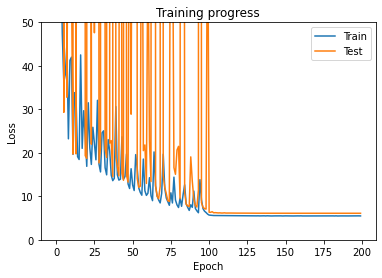

In [39]:
plt.plot(hist1.history['loss'] + hist2.history['loss'])
plt.plot(hist1.history['val_loss'] + hist2.history['val_loss'])
plt.title('Training progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.ylim(0,50)
plt.savefig('resnet_v2_adam_100_sgd_100epoch_loss.pdf')
plt.show()

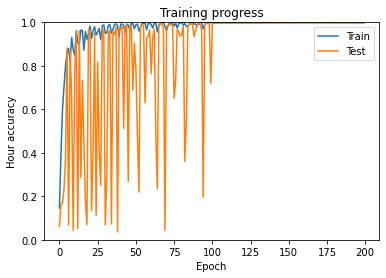

In [40]:
plt.plot(hist1.history['hour_accuracy'] + hist2.history['hour_accuracy'])
plt.plot(hist1.history['val_hour_accuracy'] + hist2.history['val_hour_accuracy'])
plt.title('Training progress')
plt.ylabel('Hour accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.ylim(0,1)
plt.savefig('resnet_v2_adam_100_sgd_100epoch_hour_accuracy.pdf')
plt.show()

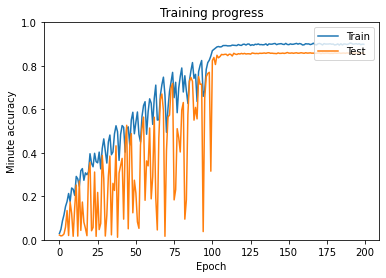

In [41]:
plt.plot(hist1.history['minute_accuracy'] + hist2.history['minute_accuracy'])
plt.plot(hist1.history['val_minute_accuracy'] + hist2.history['val_minute_accuracy'])
plt.title('Training progress')
plt.ylabel('Minute accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.ylim(0,1)
plt.savefig('resnet_v2_adam_100_sgd_100epoch_minute_accuracy.pdf')
plt.show()

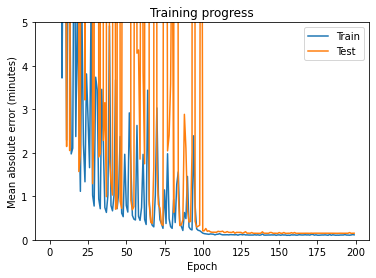

In [42]:
plt.plot(hist1.history['real_time_error'] + hist2.history['real_time_error'])
plt.plot(hist1.history['val_real_time_error'] + hist2.history['val_real_time_error'])
plt.title('Training progress')
plt.ylabel('Mean absolute error (minutes)')
plt.xlabel('Epoch')
plt.ylim(0,5)
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('resnet_v2_adam_100_sgd_100epoch_real_time.pdf')
plt.show()

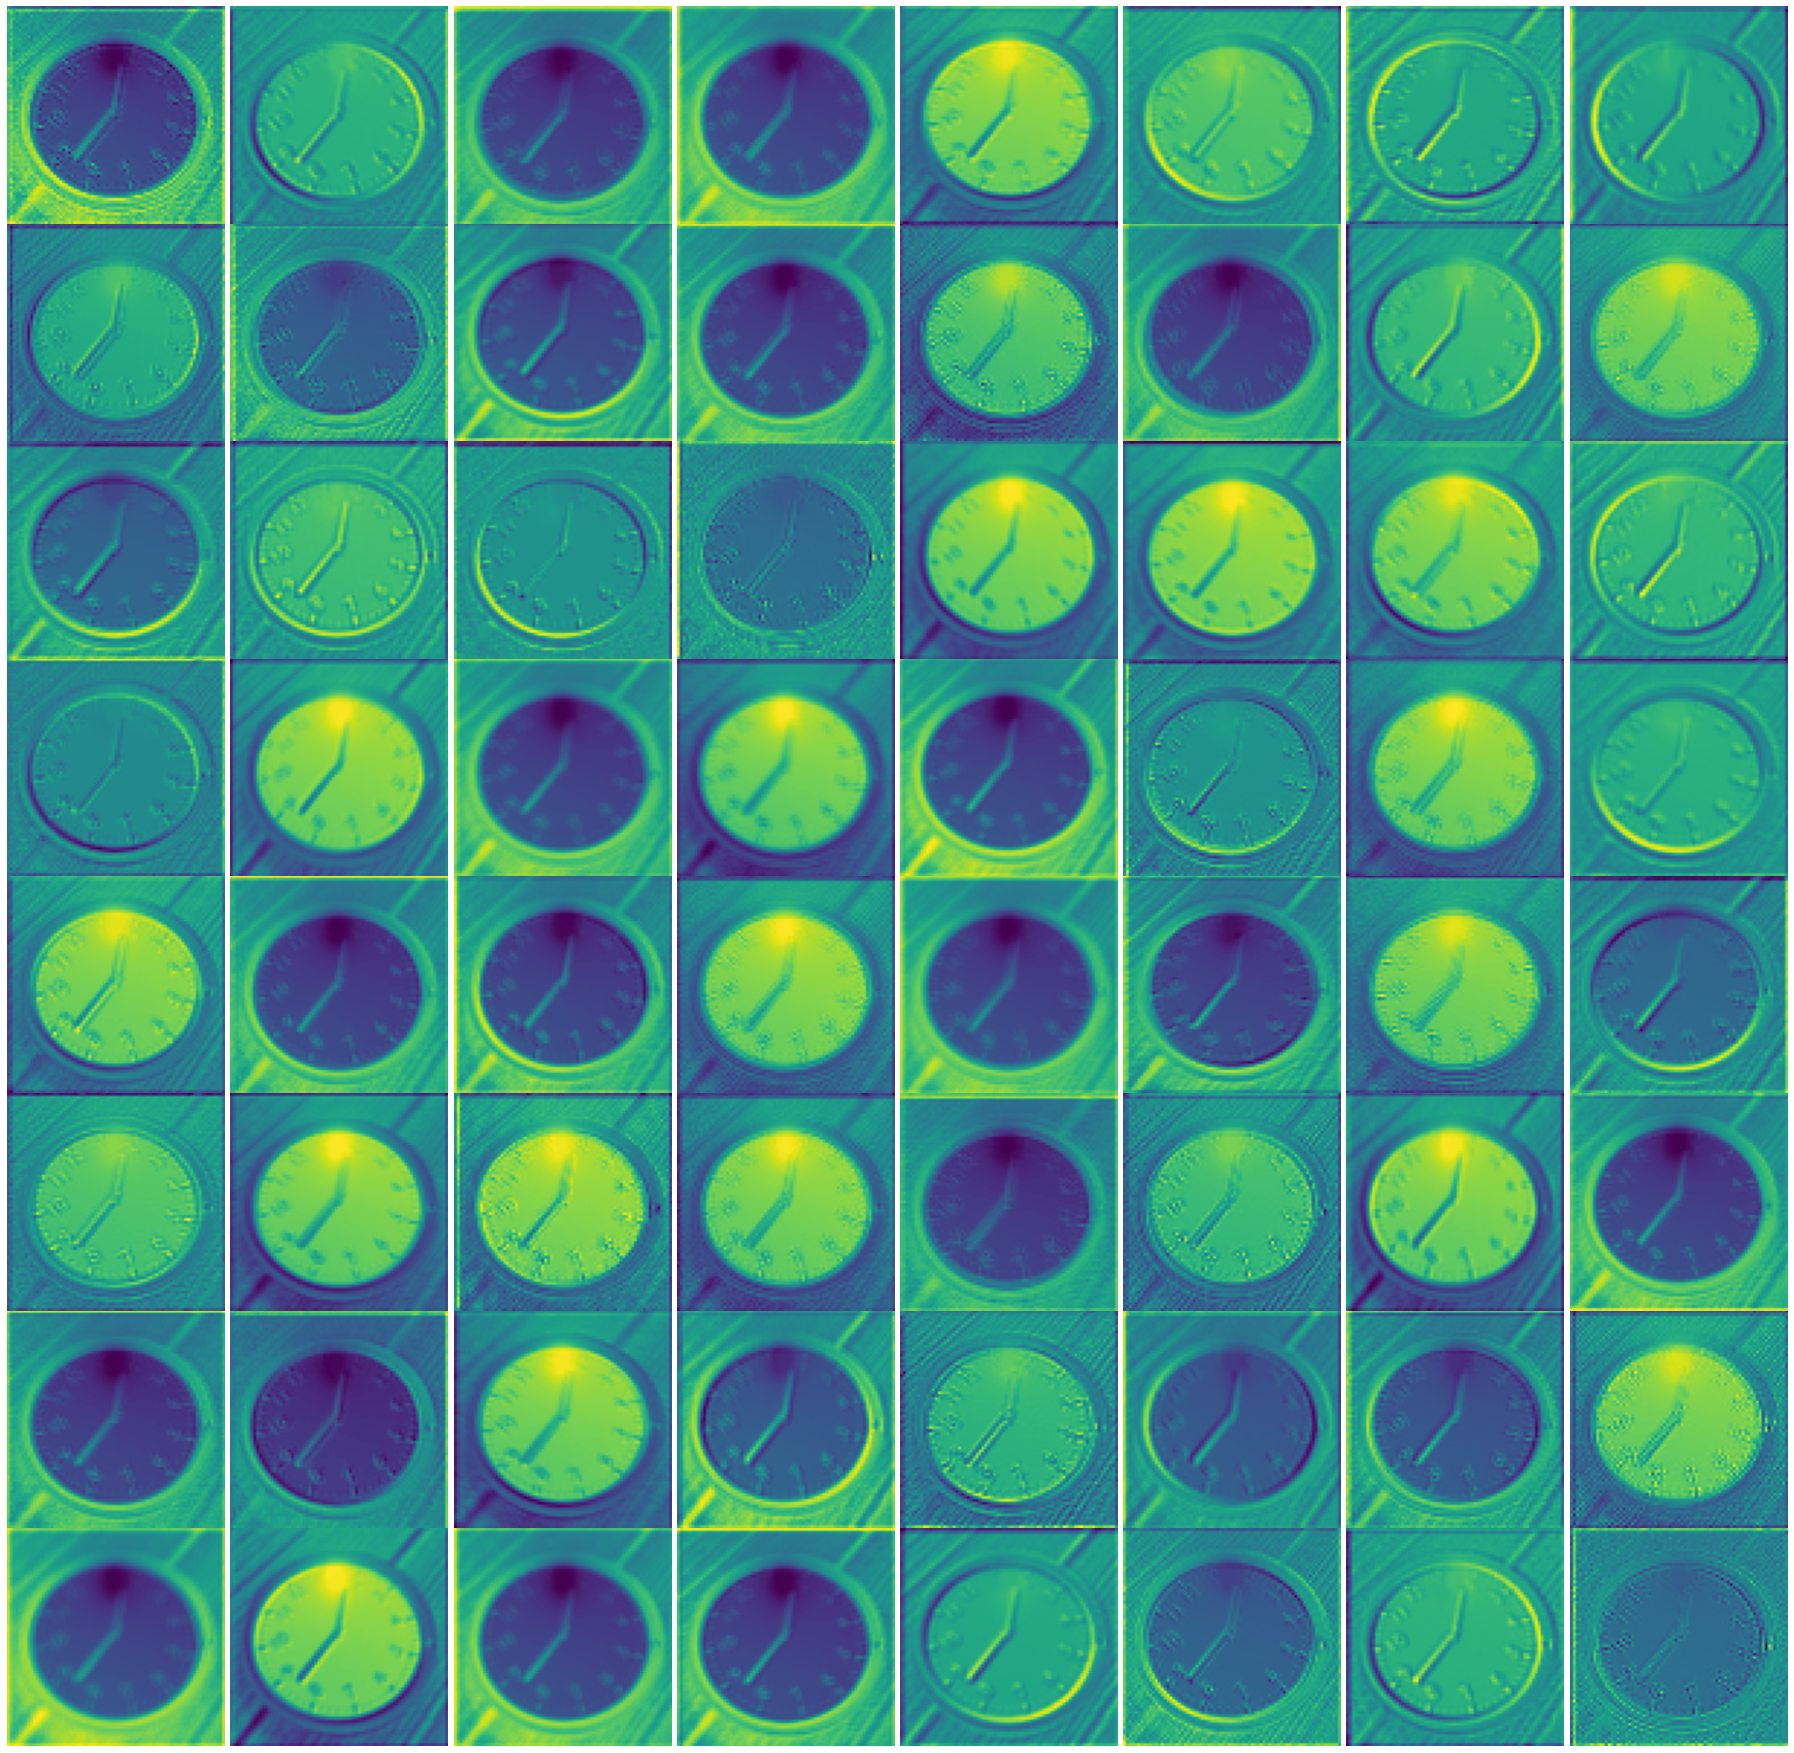

In [80]:
layer_outputs = [layer.output for layer in model.layers] 
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)
layer_activations = activation_model.predict(X_test[0:5])

def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(figsize=(32,32),ncols=ncols, nrows=nrows)
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap='viridis')
        axeslist.ravel()[ind].set_axis_off()
        axeslist.ravel()[ind].set_xticklabels([])
        axeslist.ravel()[ind].set_yticklabels([])
        axeslist.ravel()[ind].set_aspect('equal')
    fig.subplots_adjust(hspace=0, wspace=0)
    #plt.tight_layout() # optional

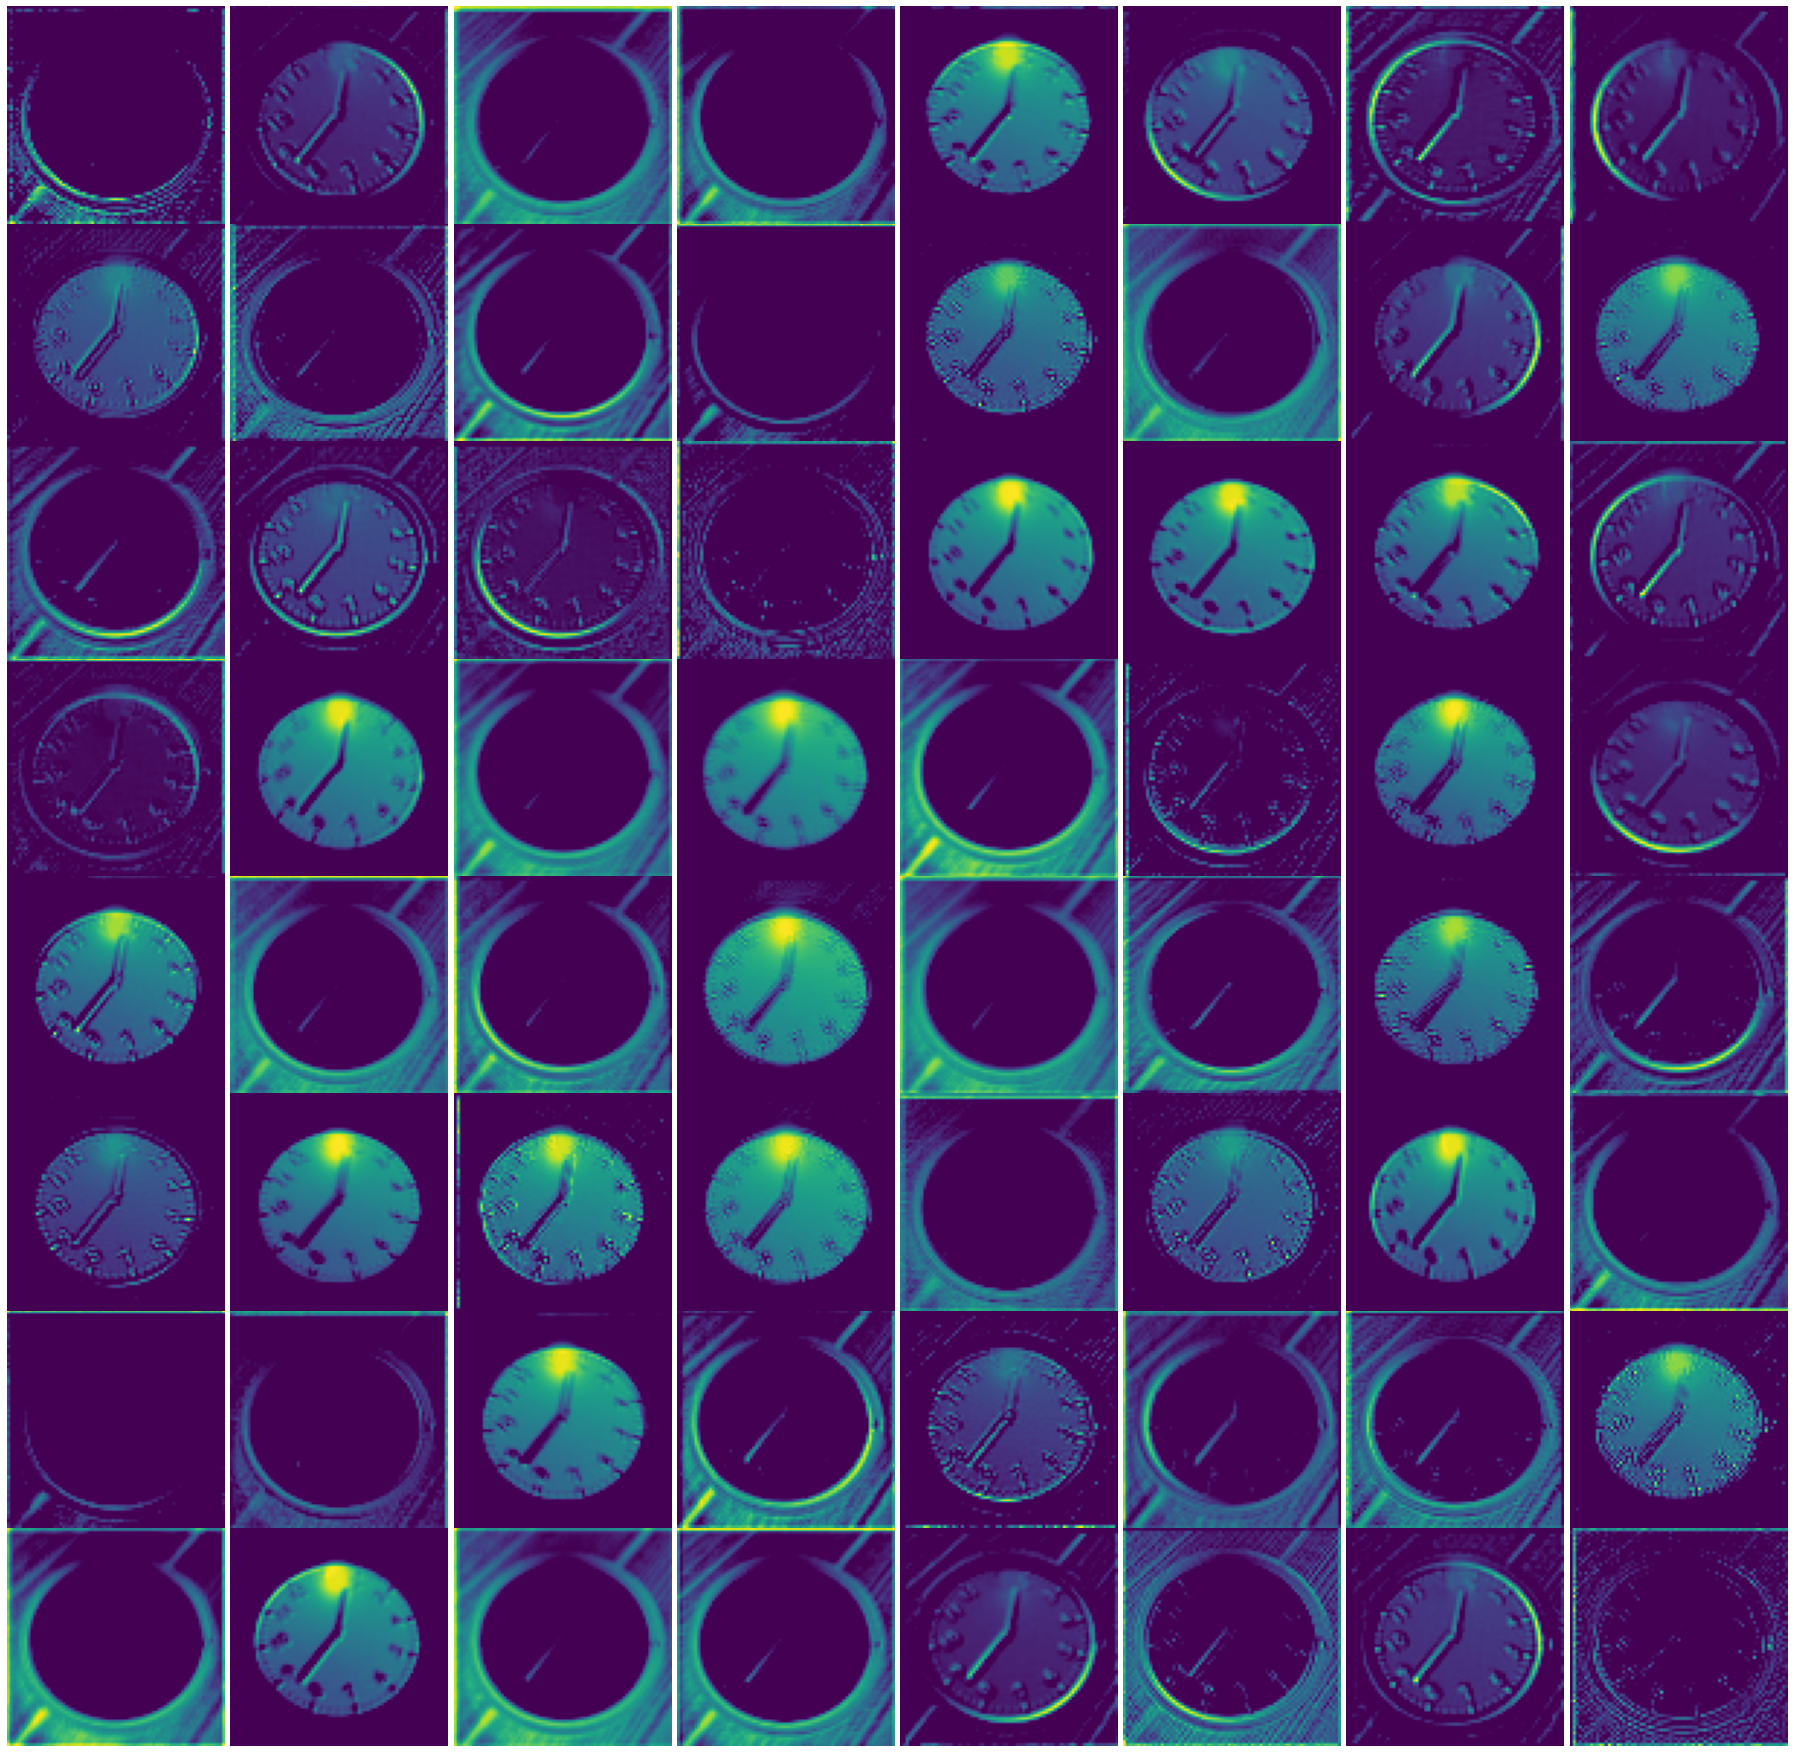

In [103]:

plot_figures({i: layer_activations[4][0, :, :, i] for i in range(64)}, 8, 8)

In [97]:
tf.keras.utils.plot_model(model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
